In [1]:
#!pip install -r requirements.txt

## Fetch Documents from MongoDB

In [1]:
from pymongo import MongoClient
import spacy

2023-07-26 23:42:48.260110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 23:42:54.215890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pandas as pd

In [3]:
client = MongoClient('mongodb://localhost:27017/') 

# Access the database
db = client['job-resume-db']  

# Access the collection
collection = db['job-descriptions'] 

In [4]:
# Fetch all the job descriptions
documents = collection.find({})  

In [5]:
job_descriptions_df = pd.DataFrame(documents)

In [6]:
job_descriptions_df.head()

,_id,index,category,description
0,649cd598eed36cf2eea926a8,0,product manager,Title: Mobile Marketing Executive Full Descrip...
1,649cd598eed36cf2eea926a9,1,product manager,Title: Product Manager IT Channel Harrogate **...
2,649cd598eed36cf2eea926aa,2,product manager,Title: PR Account Executive/PR Account Manager...
3,649cd598eed36cf2eea926ab,3,product manager,Title: Product Marketing Manager Full Descript...
4,649cd598eed36cf2eea926ac,4,product manager,Title: PR Account Manager Full Description: PR...


In [7]:
job_descriptions_df.set_index('_id',inplace=True)

In [8]:
job_categories_df, job_descriptions_df = job_descriptions_df['category'], job_descriptions_df['description']

In [9]:
job_descriptions_df.head()

_id
649cd598eed36cf2eea926a8    Title: Mobile Marketing Executive Full Descrip...
649cd598eed36cf2eea926a9    Title: Product Manager IT Channel Harrogate **...
649cd598eed36cf2eea926aa    Title: PR Account Executive/PR Account Manager...
649cd598eed36cf2eea926ab    Title: Product Marketing Manager Full Descript...
649cd598eed36cf2eea926ac    Title: PR Account Manager Full Description: PR...
Name: description, dtype: object

In [10]:
job_categories_df.head()

_id
649cd598eed36cf2eea926a8    product manager
649cd598eed36cf2eea926a9    product manager
649cd598eed36cf2eea926aa    product manager
649cd598eed36cf2eea926ab    product manager
649cd598eed36cf2eea926ac    product manager
Name: category, dtype: object

## Pre-Processing and Removing Noisy words

In [11]:
import re
from tqdm.notebook import tqdm
import warnings
import pickle

warnings.filterwarnings(action='ignore')

In [12]:
# Load Spacy model
nlp = spacy.load('en_core_web_trf')

In [13]:
# Open the text file and read the lines into a list
with open('noisy_words.txt', 'r') as f:
    words = f.readlines()

# Remove any newline characters from each word
noisy_words = [word.strip() for word in words]

In [14]:
def preprocess_text(text):
    # Define words to remove
    words_to_remove = noisy_words

    # Remove 'title'
    text = re.sub(r'\btitle\b', '', text, flags=re.I)
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Apply Spacy model
    doc = nlp(text)
    # Only keep relevant POS: noun and adjectives, and not stop words, and meet the other conditions
    return " ".join([token.lemma_.lower() for token in doc if token.pos_ in ['NOUN', 'PROPN']
                     and not token.is_stop
                     and token.ent_type_ != "GPE"  # This checks that the word is not a location
                     and (len(token.text) > 1 or token.text.lower() == 'c' or token.text.lower() == 'r')  # This checks that the word is not a single letter, except 'c'
                     and not (len(token.text) == 2 and token.text[0] == token.text[1])  # This checks that the word is not a two-letter word with repeating letters
                     and token.lemma_.lower() not in words_to_remove])  # This checks if the word is in the list of words to remove


In [15]:
# Preprocess all descriptions
preprocessed_descriptions = [preprocess_text(desc) for desc in tqdm(job_descriptions_df, desc="Cleaning and Preprocessing: ")]

Cleaning and Preprocessing:   0%|          | 0/3530 [00:00<?, ?it/s]

In [17]:
# Save the preprocessed_descriptions to a pickle file
with open('preprocessed_descriptions.pkl', 'wb') as f:
    pickle.dump(preprocessed_descriptions, f)

In [12]:
import pickle

with open('preprocessed_descriptions.pkl', 'rb') as f:
    preprocessed_descriptions = pickle.load(f)

### Exploring unigrams and bigrams which are most and least common

In [16]:
import nltk
from nltk.corpus import stopwords

# You need to download the stopwords package
nltk.download('stopwords')

# Create a set of English stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to get the top N-grams from a corpus
def get_top_ngrams(corpus, ngram_range, stop_words, limit):
    # Create a CountVectorizer object with specified N-gram range and stop words
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(corpus)
    # Transform the corpus into a bag of words
    bag_of_words = vec.transform(corpus)
    # Sum the word frequencies for each N-gram
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of (word, frequency) pairs
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
     # Sort the list in descending order of word frequency
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Return the top N-grams up to the specified limit
    return words_freq[:limit]

# Function to get the bottom N-grams from a corpus
def get_bottom_ngrams(corpus, ngram_range, stop_words, limit):
    # Create a CountVectorizer object with specified N-gram range and stop words
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(corpus)
    # Transform the corpus into a bag of words
    bag_of_words = vec.transform(corpus)
    # Sum the word frequencies for each N-gram
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of (word, frequency) pairs
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the list in ascending order of word frequency
    words_freq = sorted(words_freq, key = lambda x: x[1])
    # Return the bottom N-grams up to the specified limit
    return words_freq[:limit]


In [18]:
# Get the top 100 unigrams (single words) from preprocessed descriptions
top_100_unigrams = get_top_ngrams(preprocessed_descriptions, ngram_range=(1,1), stop_words=stop_words, limit=100)
# Print the top 100 unigrams
print("Top 100 Unigrams: ", top_100_unigrams)
# Get the top 100 bigrams (two-word phrases) from preprocessed descriptions
top_100_bigrams = get_top_ngrams(preprocessed_descriptions, ngram_range=(2,2), stop_words=stop_words, limit=100)
# Print the top 100 bigrams
print("Top 100 Bigrams: ", top_100_bigrams)

Top 100 Unigrams:  [('software', 12579), ('developer', 10943), ('development', 7667), ('net', 7528), ('role', 5427), ('product', 5348), ('business', 3860), ('company', 3806), ('sql', 3589), ('web', 3169), ('job', 3052), ('project', 2830), ('technology', 2800), ('asp', 2750), ('java', 2701), ('manager', 2694), ('candidate', 2498), ('server', 2346), ('environment', 2325), ('management', 2217), ('knowledge', 2197), ('system', 2001), ('design', 1941), ('service', 1939), ('engineer', 1912), ('solution', 1832), ('marketing', 1717), ('year', 1589), ('senior', 1527), ('customer', 1521), ('market', 1512), ('career', 1428), ('position', 1417), ('vb', 1381), ('communication', 1365), ('level', 1345), ('agency', 1330), ('javascript', 1329), ('benefit', 1319), ('html', 1296), ('support', 1284), ('recruitment', 1221), ('firm', 1163), ('employment', 1153), ('industry', 1130), ('responsibility', 1126), ('jobseeking', 1077), ('css', 1056), ('account', 1038), ('group', 1038), ('php', 1024), ('time', 1013

In [19]:
# Get the bottom 100 unigrams from the preprocessed descriptions
bottom_100_unigrams = get_bottom_ngrams(preprocessed_descriptions, ngram_range=(1,1), stop_words=stop_words, limit=100)
# Print the bottom 100 unigrams
print("Bottom 100 Unigrams: ", bottom_100_unigrams)
# Get the bottom 100 bigrams from the preprocessed descriptions
bottom_100_bigrams = get_bottom_ngrams(preprocessed_descriptions, ngram_range=(2,2), stop_words=stop_words, limit=100)
# Print the bottom 100 bigrams
print("Bottom 100 Unigrams: ", bottom_100_bigrams)

Bottom 100 Unigrams:  [('mobilemarketingexecutive_job', 1), ('kb', 1), ('praccountexecutivepraccountmanager_job', 1), ('abm', 1), ('hoolahan', 1), ('ifs', 1), ('interdependency', 1), ('stride', 1), ('rigour', 1), ('upskilling', 1), ('storyline', 1), ('elucidate', 1), ('brave', 1), ('diplomacy', 1), ('tact', 1), ('bbproductmanager_job', 1), ('oxon', 1), ('eed', 1), ('identifyi', 1), ('orecasting', 1), ('vo', 1), ('atalogue', 1), ('roject', 1), ('effecti', 1), ('ukproductmanageroxonmcorridor_job', 1), ('spiff', 1), ('productmanagernorthithardware_job', 1), ('pooling', 1), ('sweeping', 1), ('houseware', 1), ('traveler', 1), ('sitemap', 1), ('mortem', 1), ('escenic', 1), ('applicor', 1), ('tension', 1), ('hawker', 1), ('frenchspeakingproductmanager_job', 1), ('emeai', 1), ('associations', 1), ('marketingmanager_job', 1), ('coop', 1), ('fsdu', 1), ('treat', 1), ('aquatics', 1), ('affiliates', 1), ('uktrademarketingassistant_job', 1), ('vbe', 1), ('stabilisation', 1), ('rts', 1), ('sgii', 1)

In [20]:
# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

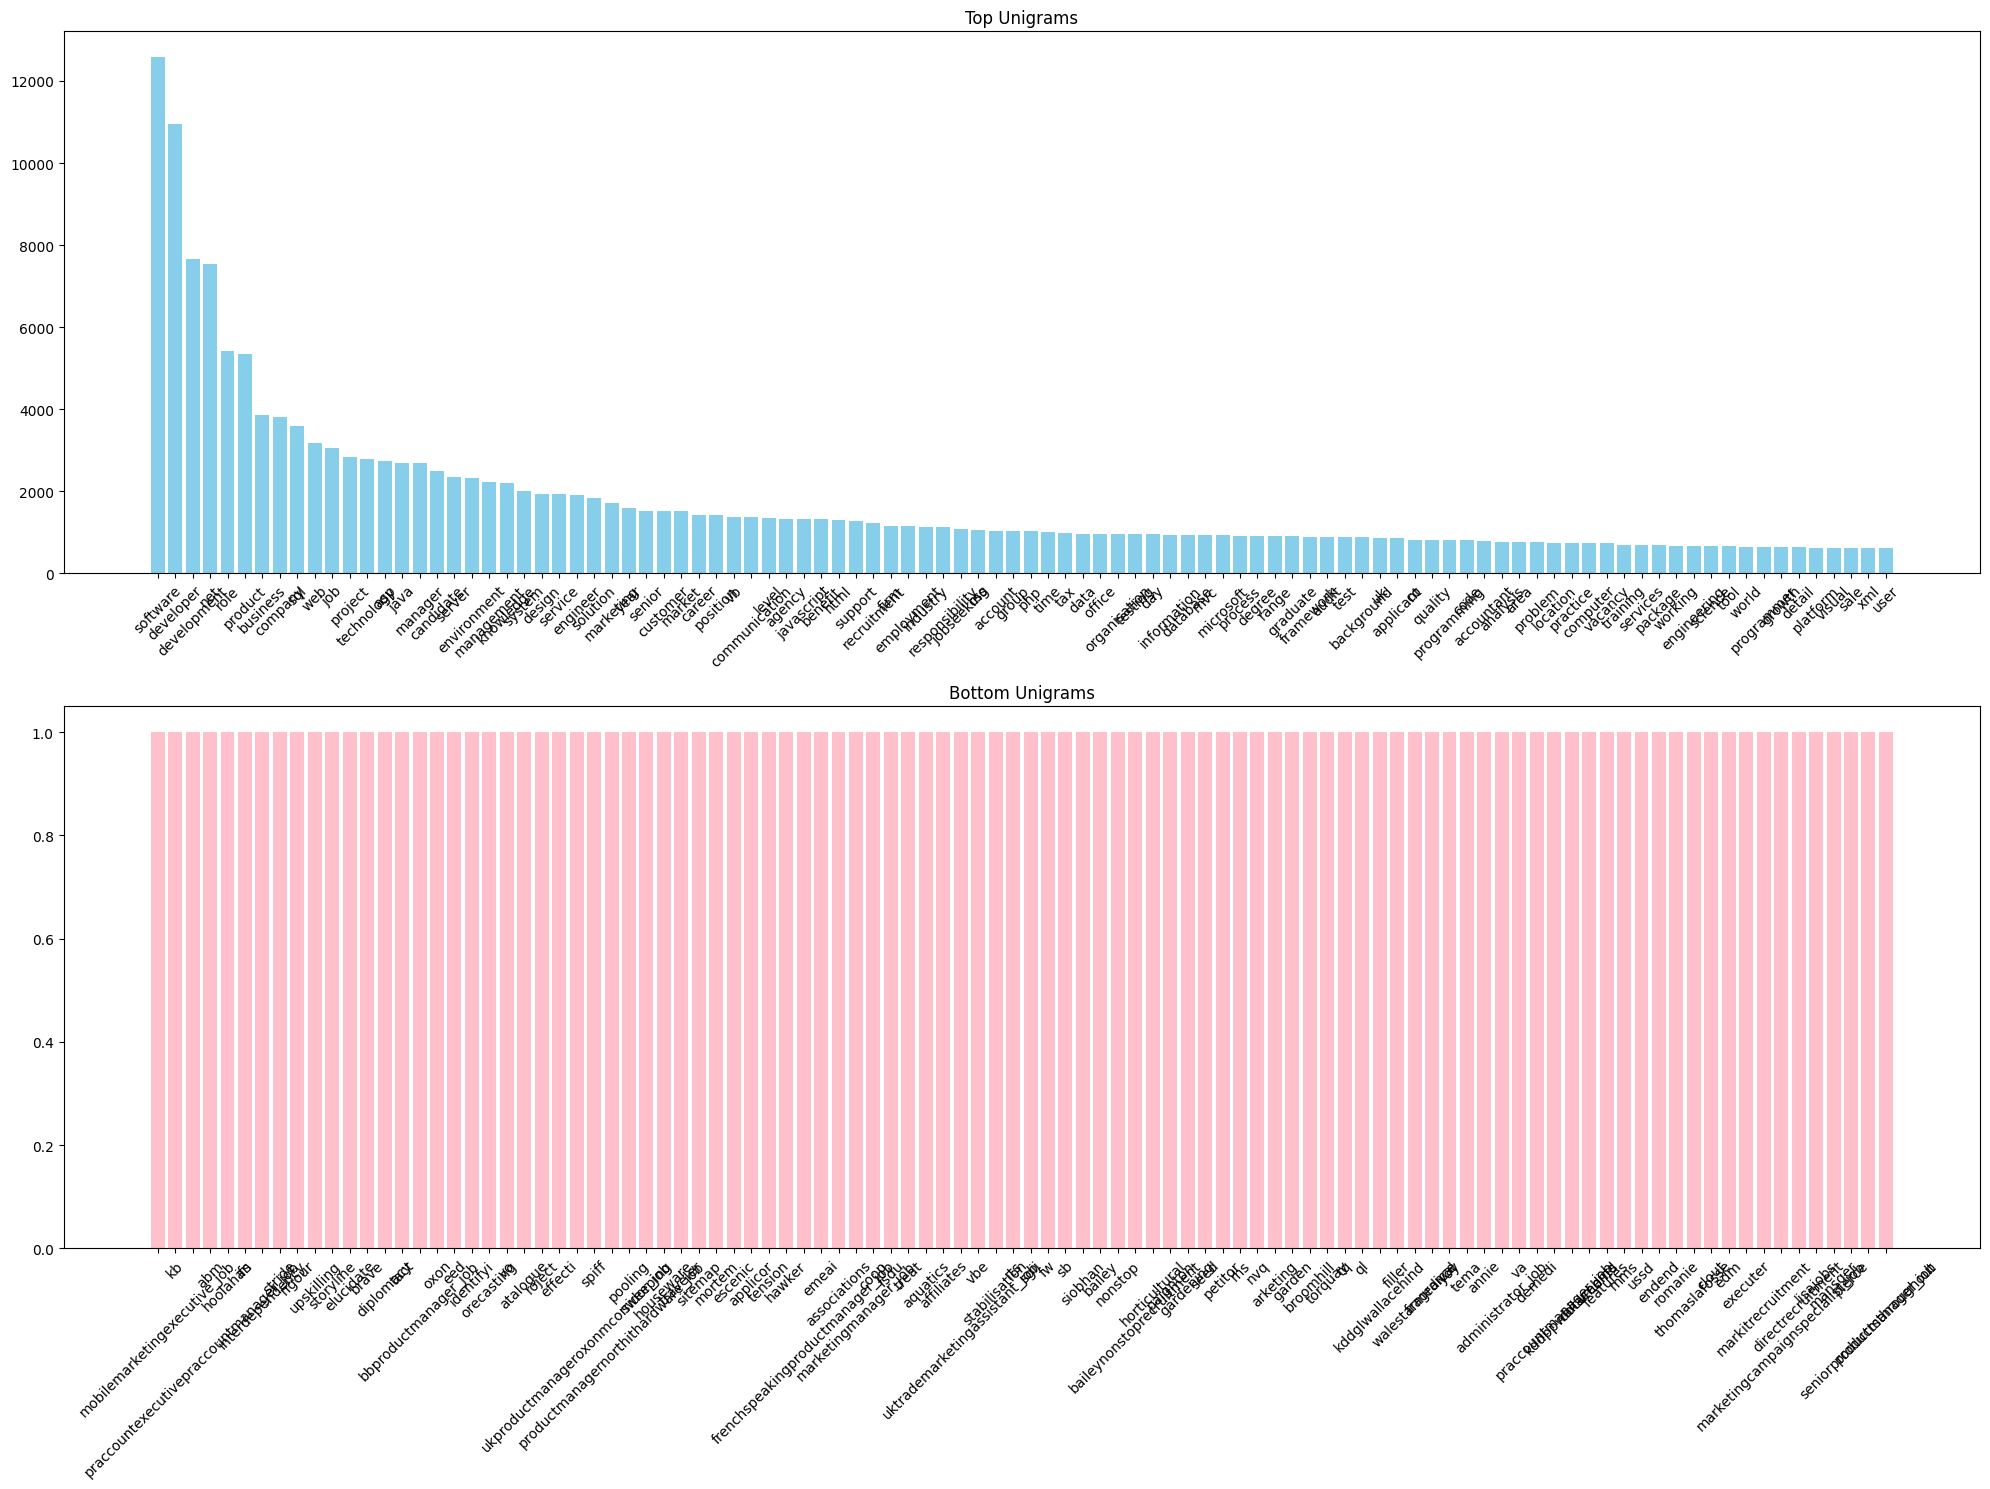

In [21]:
import matplotlib.pyplot as plt

# Unigrams
top_unigram_words = [i[0] for i in top_100_unigrams]
top_unigram_values = [i[1] for i in top_100_unigrams]

bottom_unigram_words = [i[0] for i in bottom_100_unigrams]
bottom_unigram_values = [i[1] for i in bottom_100_unigrams]

fig, axs = plt.subplots(2, figsize=(20,15))

axs[0].bar(top_unigram_words, top_unigram_values, color='skyblue')
axs[0].set_title('Top Unigrams')
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)

axs[1].bar(bottom_unigram_words, bottom_unigram_values, color='pink')
axs[1].set_title('Bottom Unigrams')
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

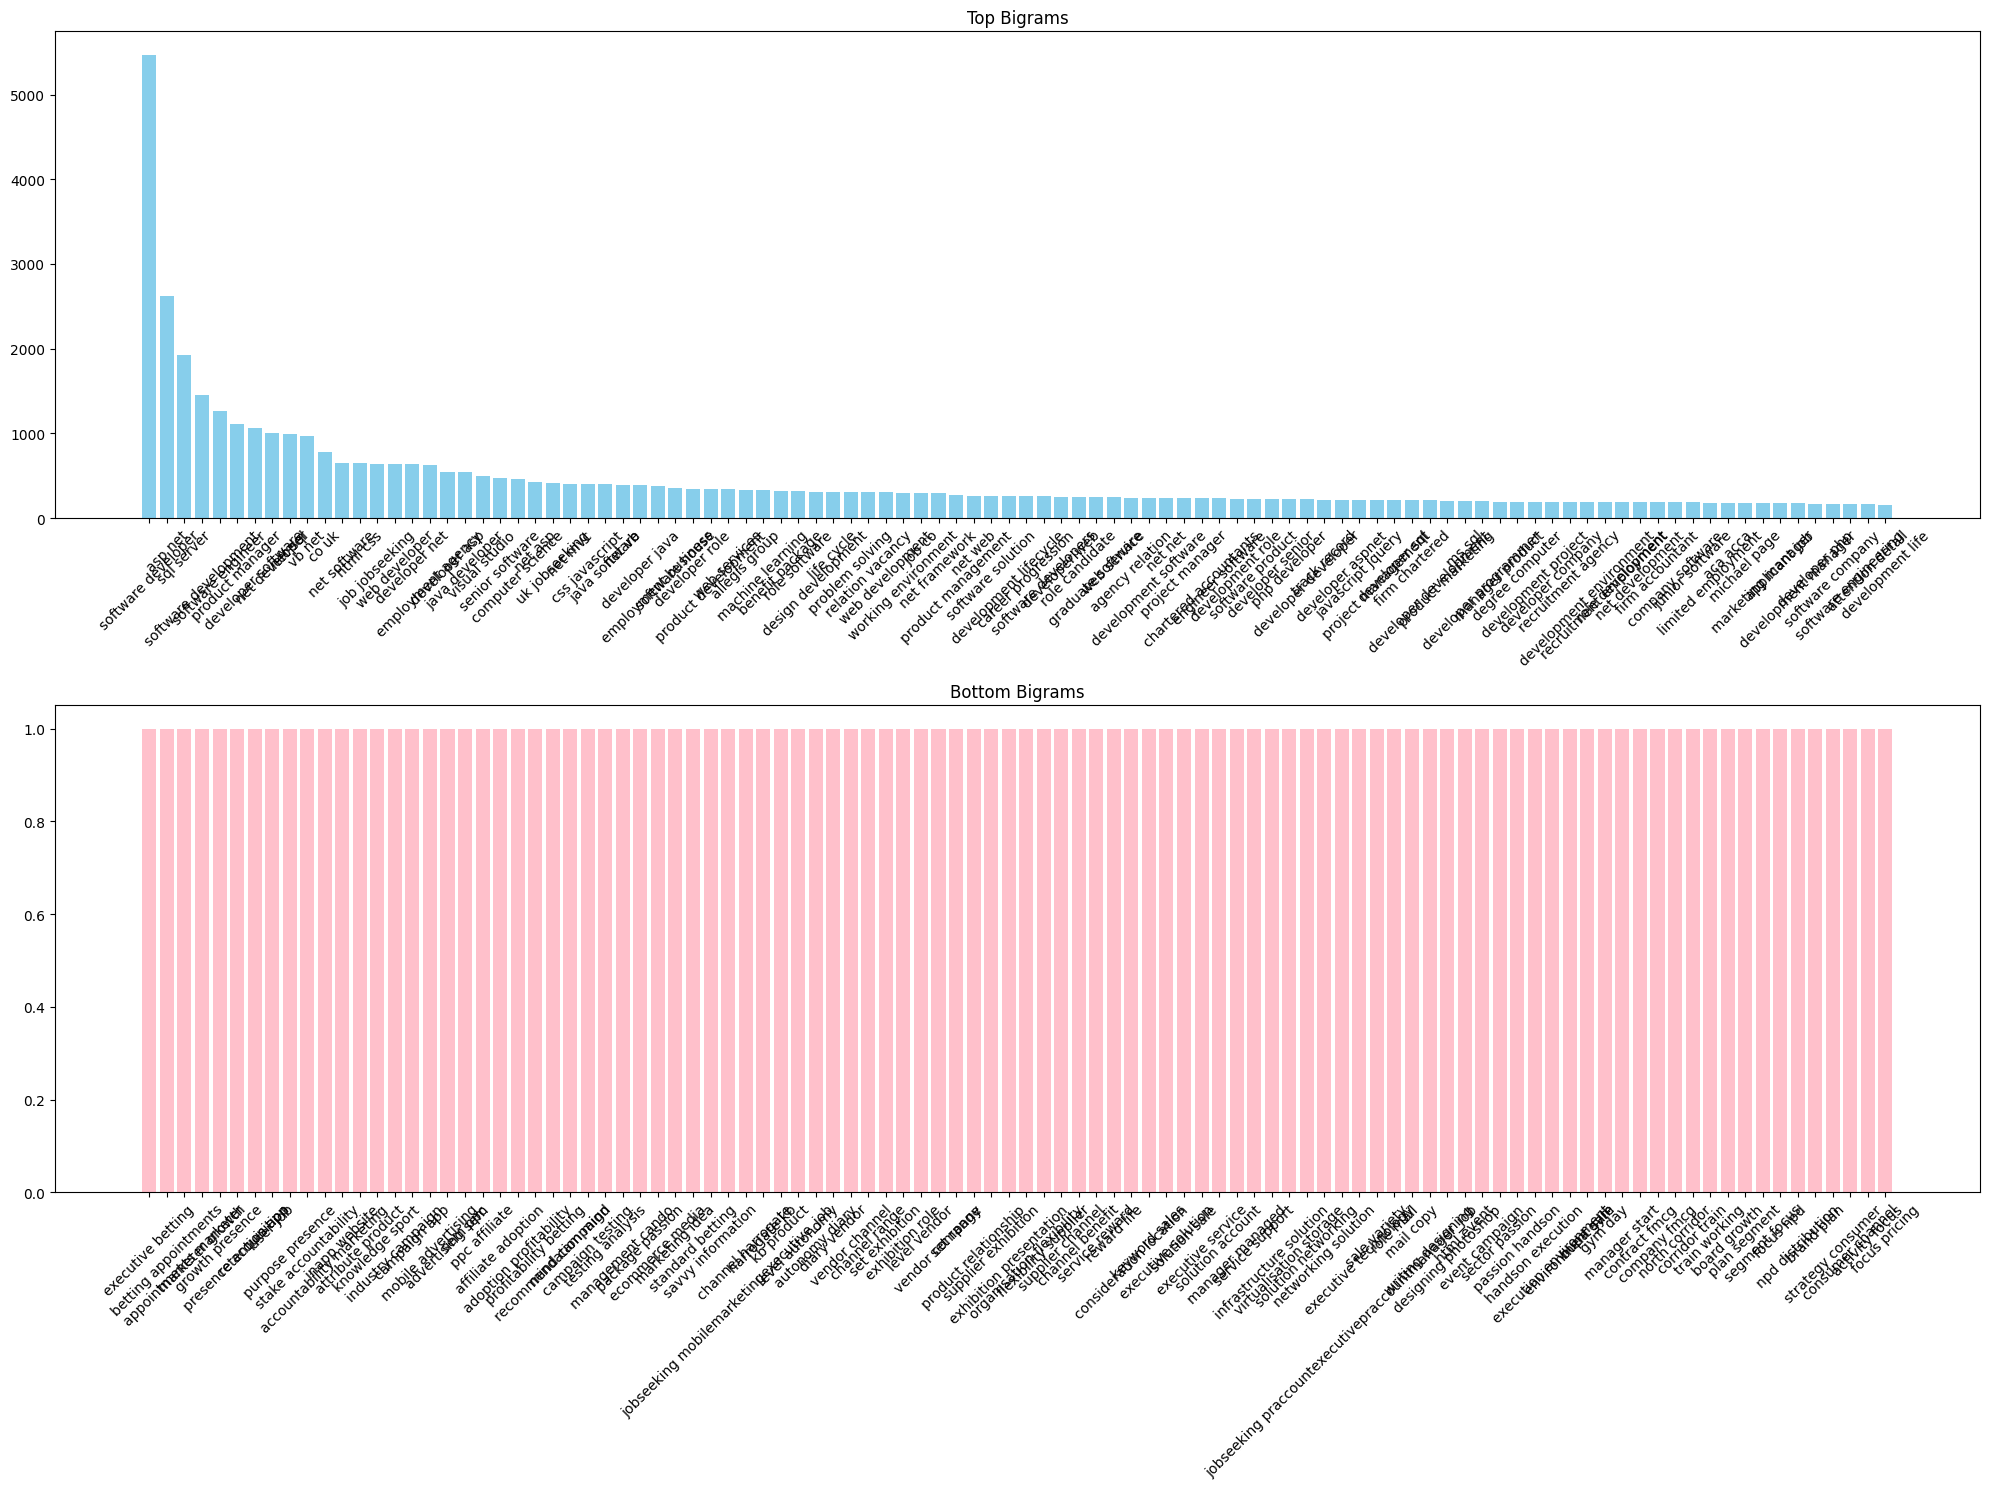

In [22]:
# Bigrams
top_bigram_words = [i[0] for i in top_100_bigrams]
top_bigram_values = [i[1] for i in top_100_bigrams]

bottom_bigram_words = [i[0] for i in bottom_100_bigrams]
bottom_bigram_values = [i[1] for i in bottom_100_bigrams]

fig, axs = plt.subplots(2, figsize=(20,15))

axs[0].bar(top_bigram_words, top_bigram_values, color='skyblue')
axs[0].set_title('Top Bigrams')
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)

axs[1].bar(bottom_bigram_words, bottom_bigram_values, color='pink')
axs[1].set_title('Bottom Bigrams')
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Least Common Words

In [23]:
import nltk

In [24]:
# Convert the preprocessed descriptions into a single list
all_words = [word for desc in preprocessed_descriptions for word in desc.split()]

# Create a frequency distribution
freq_dist = nltk.FreqDist(all_words)

In [25]:
# Convert the preprocessed descriptions into a single list
all_words = [word for desc in preprocessed_descriptions for word in desc.split()]

# Create a frequency distribution
freq_dist = nltk.FreqDist(all_words)
least_common = freq_dist.most_common()[:-101:-1]

In [26]:
words = [word[0] for word in list(least_common)]
# Now, convert each word to a line in a text file
lines = [word + '\n' for word in words]

# Now, write the lines to a text file
with open('least_common.txt', 'w') as f:
    f.writelines(lines)

### Least Unigram and Bigram Frequency Words

In [27]:
bottom_100_unigrams

[('mobilemarketingexecutive_job', 1),
 ('kb', 1),
 ('praccountexecutivepraccountmanager_job', 1),
 ('abm', 1),
 ('hoolahan', 1),
 ('ifs', 1),
 ('interdependency', 1),
 ('stride', 1),
 ('rigour', 1),
 ('upskilling', 1),
 ('storyline', 1),
 ('elucidate', 1),
 ('brave', 1),
 ('diplomacy', 1),
 ('tact', 1),
 ('bbproductmanager_job', 1),
 ('oxon', 1),
 ('eed', 1),
 ('identifyi', 1),
 ('orecasting', 1),
 ('vo', 1),
 ('atalogue', 1),
 ('roject', 1),
 ('effecti', 1),
 ('ukproductmanageroxonmcorridor_job', 1),
 ('spiff', 1),
 ('productmanagernorthithardware_job', 1),
 ('pooling', 1),
 ('sweeping', 1),
 ('houseware', 1),
 ('traveler', 1),
 ('sitemap', 1),
 ('mortem', 1),
 ('escenic', 1),
 ('applicor', 1),
 ('tension', 1),
 ('hawker', 1),
 ('frenchspeakingproductmanager_job', 1),
 ('emeai', 1),
 ('associations', 1),
 ('marketingmanager_job', 1),
 ('coop', 1),
 ('fsdu', 1),
 ('treat', 1),
 ('aquatics', 1),
 ('affiliates', 1),
 ('uktrademarketingassistant_job', 1),
 ('vbe', 1),
 ('stabilisation', 1

In [30]:
# Open a file named 'bottom_100_unigram_words.txt' in write mode ('w')
# This will create the file if it doesn't exist or overwrite it if it does exist.

with open('bottom_100_unigram_words.txt', 'w') as f:
    # Iterate through each word in the list 'bottom_100_unigrams'
    for word in bottom_100_unigrams:
        # Write the current word followed by a newline character to the file
        # Each word will be written on a separate line in the file.
        f.write("%s\n" % word[0])

In [31]:
# Open a file named 'bottom_100_bigram_words.txt' in write mode ('w')
with open('bottom_100_bigram_words.txt', 'w') as f:
    # Iterate through each (word, frequency) tuple in the 'bottom_100_bigrams' list
    for word in bottom_100_bigrams:
        # Write the first element of the tuple (the word) to the file followed by a newline character
        f.write("%s\n" % word[0])

### Removing Least Common, Least frequent Unigrams and Bigrams from the corpus to remove noise

In [28]:
import re

# Function to load noisy words from files
def load_noisy_words(filepaths):
    noisy_words = []
    for filepath in filepaths:
        with open(filepath, 'r') as f:
            words = f.read().splitlines() # Read lines from the file
            noisy_words.extend(words) # Add the words to the noisy_words list
    return noisy_words

# Function to clean job descriptions by removing noisy words
def clean_job_descriptions(descriptions, noisy_words):
    cleaned_descriptions = []
    for desc in tqdm(descriptions, desc="Removing Noisy Words from Job Descriptions: "):
        cleaned_description = desc
        # Iterate through noisy words and remove them from the description
        for word in noisy_words:
            pattern = r'\b' + word + r'\b'
            cleaned_description = re.sub(pattern, '', cleaned_description)
        # Remove extra whitespaces to clean the description
        cleaned_description = re.sub(' +', ' ', cleaned_description)
        cleaned_descriptions.append(cleaned_description.strip())
    return cleaned_descriptions

In [29]:
# Load noisy words from text files
filepaths = ['bottom_100_unigram_words.txt', 'bottom_100_bigram_words.txt', 'least_common.txt', 'noisy_words.txt']
noisy_words = load_noisy_words(filepaths)

# Clean job descriptions
cleaned_job_descriptions = clean_job_descriptions(preprocessed_descriptions, noisy_words)

Removing Noisy Words from Job Descriptions:   0%|          | 0/3530 [00:00<?, ?it/s]

In [30]:
# Get the top 100 unigrams (single words) from the cleaned job descriptions.
top_100_unigrams = get_top_ngrams(cleaned_job_descriptions, ngram_range=(1,1), stop_words=stop_words, limit=100)
# Print the top 100 unigrams.
print("Top 100 Unigrams: ", top_100_unigrams)
# Get the top 100 bigrams (two-word combinations) from the cleaned job descriptions.
top_100_bigrams = get_top_ngrams(cleaned_job_descriptions, ngram_range=(2,2), stop_words=stop_words, limit=100)
# Print the top 100 bigrams.
print("Top 100 Bigrams: ", top_100_bigrams)

Top 100 Unigrams:  [('software', 12579), ('developer', 10943), ('development', 7667), ('net', 7528), ('role', 5426), ('product', 5346), ('business', 3860), ('company', 3805), ('sql', 3589), ('web', 3169), ('job', 3051), ('project', 2830), ('technology', 2799), ('asp', 2750), ('java', 2701), ('manager', 2692), ('candidate', 2498), ('server', 2346), ('environment', 2324), ('management', 2216), ('knowledge', 2196), ('system', 2001), ('design', 1941), ('service', 1936), ('engineer', 1912), ('solution', 1828), ('marketing', 1716), ('year', 1589), ('senior', 1527), ('customer', 1521), ('market', 1512), ('career', 1428), ('position', 1417), ('vb', 1381), ('communication', 1365), ('level', 1343), ('agency', 1330), ('javascript', 1329), ('benefit', 1319), ('html', 1295), ('support', 1283), ('recruitment', 1221), ('firm', 1163), ('employment', 1153), ('industry', 1129), ('responsibility', 1126), ('jobseeking', 1077), ('css', 1056), ('group', 1038), ('account', 1037), ('php', 1024), ('time', 1013

In [31]:
# Get the bottom 100 unigrams (single words) from the cleaned job descriptions
bottom_100_unigrams = get_bottom_ngrams(cleaned_job_descriptions, ngram_range=(1,1), stop_words=stop_words, limit=100)
# Print the bottom 100 unigrams
print("Bottom 100 Unigrams: ", bottom_100_unigrams)
# Get the bottom 100 bigrams (two-word phrases) from the cleaned job descriptions
bottom_100_bigrams = get_bottom_ngrams(cleaned_job_descriptions, ngram_range=(2,2), stop_words=stop_words, limit=100)
# Print the bottom 100 bigrams
print("Bottom 100 Unigrams: ", bottom_100_bigrams)

Bottom 100 Unigrams:  [('fae', 1), ('applicability', 1), ('endorsement', 1), ('microprocessor', 1), ('risc', 1), ('shares', 1), ('units', 1), ('saye', 1), ('ebanking', 1), ('developme', 1), ('inmarketto', 1), ('huntress', 1), ('cbpf', 1), ('fca', 1), ('ssc', 1), ('closebrothers', 1), ('accessories', 1), ('impulse', 1), ('temp', 1), ('hollydigitalgurus', 1), ('cartoon', 1), ('mechanic', 1), ('ab', 1), ('colebourne', 1), ('startuptype', 1), ('ciklum', 1), ('cmo', 1), ('sem', 1), ('swayne', 1), ('freetoplay', 1), ('pjm', 1), ('kddg', 1), ('vehicles', 1), ('garage', 1), ('processsales', 1), ('numerical', 1), ('theautomotive', 1), ('industrynew', 1), ('roleall', 1), ('noteyou', 1), ('clientsyou', 1), ('advertorial', 1), ('proofreading', 1), ('crossteam', 1), ('signing', 1), ('alliances', 1), ('admissions', 1), ('crms', 1), ('javabased', 1), ('rtb', 1), ('programs', 1), ('crosssector', 1), ('boardlevel', 1), ('robustness', 1), ('endconsumer', 1), ('traveller', 1), ('quoting', 1), ('sincher',

## Converting Job Descriptions using Doc2Vec

### Training Doc2Vec Model

In [25]:
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize

In [37]:
# Preprocessing data and tagging each document with its index
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(cleaned_job_descriptions)]

In [38]:
tagged_data[:2]

[TaggedDocument(words=['mobile', 'marketing', 'acquisition', 'kpi', 'download', 'usage', 'bettor', 'retention', 'marketing', 'acquisition', 'strategy', 'channel', 'objective', 'result', 'recommendation', 'campaign', 'optimisation', 'customer', 'product', 'creation', 'marketing', 'campaign', 'qr', 'code', 'advertising', 'push', 'notification', 'technology', 'incentive', 'programme', 'incentive', 'analysis', 'conversion', 'acquisition', 'betting', 'respect', 'marketing', 'activity', 'creation', 'crm', 'programme', 'user', 'mobile', 'marketing', 'activity', 'budget', 'forecasting', 'spend', 'industry', 'tech', 'activity', 'innovation', 'change', 'mobile', 'handset', 'technology', 'impact', 'marketing', 'design', 'resource', 'communication', 'digital', 'marketing', 'manager', 'development', 'product', 'service', 'user', 'department', 'marketer', 'tablet', 'website', 'product', 'manager', 'colleague', 'insight', 'department', 'customer', 'survey', 'product', 'goal', 'offer', 'party', 'custo

In [39]:
# Defining model parameters
doc2vec_model_unoptimized = doc2vec.Doc2Vec(vector_size=384, min_count=5, epochs=500)

In [40]:
# Building a vocab
doc2vec_model_unoptimized.build_vocab(tagged_data)

In [41]:
# Training the model
doc2vec_model_unoptimized.train(tagged_data, total_examples=doc2vec_model_unoptimized.corpus_count, epochs=doc2vec_model_unoptimized.epochs)

### Hyperparameter Tuning of Doc2Vec

In [41]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [42]:
# Create a label (category) encoder object
le = LabelEncoder()

In [43]:
# Fit the encoder to the pandas column
le.fit(job_categories_df)
encoded_job_category = le.transform(job_categories_df)

In [51]:
# Split the dataset into 70% training and 30% temporary set
train_descriptions, temp_descriptions, train_categories, temp_categories = train_test_split(
    job_descriptions_df, job_categories_df, stratify=job_categories_df, test_size=0.3, random_state=42)

# Split the temporary set into 66.67% validation and 33.33% test set
valid_descriptions, test_descriptions, valid_categories, test_categories = train_test_split(
    temp_descriptions, temp_categories, stratify=temp_categories, test_size=1/3, random_state=42)

In [51]:
# Performing the hyperparameter tuning based on the logic that if the converted vector is able to accurately classify the job description category then, it is good
best_accuracy = 0
best_params = {}

# Loop over different combinations of hyperparameters
for vector_size in [50, 100, 150, 200, 300, 384]:
    for epochs in [10, 20, 30, 50, 100, 500]:
        for min_count in [2, 5, 10, 15]:
            for window in [2, 5, 10, 15]:
                # Print the current combination being evaluated
                print("=> Trying combination: ", {'vector_size': vector_size, 'min_count': min_count, 'epochs': epochs, 'window': window})    
                # Define the Doc2Vec model with the current hyperparameters
                model = doc2vec.Doc2Vec(vector_size=vector_size, window=window, epochs=epochs, min_count= min_count)

                # Prepare training data as TaggedDocuments
                documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_descriptions)]

                # Build the vocabulary using the training data
                model.build_vocab(documents)

                # Train the Doc2Vec model on the training data
                model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

                # Infer vectors for the training and validation data
                train_vectors = [model.infer_vector(doc.split()) for doc in train_descriptions]
                valid_vectors = [model.infer_vector(doc.split()) for doc in valid_descriptions]

                # Initialize an SVM classifier
                svm_model = SVC()
                # Train the SVM classifier on the training vectors and labels
                svm_model.fit(train_vectors, train_categories)
                # Make predictions on the validation data
                predictions = svm_model.predict(valid_vectors)
                # Calculate accuracy on the validation data
                accuracy = accuracy_score(valid_categories, predictions)

                # If current accuracy is better than previous best, evaluate on the test set
                # and update the best accuracy and hyperparameters
                if accuracy > best_accuracy:
                    # Infer vectors for the test data
                    test_vectors = [model.infer_vector(doc.split()) for doc in test_descriptions]
                    # Make predictions on the test data
                    test_predictions = svm_model.predict(test_vectors)
                    # Calculate accuracy on the test data
                    test_accuracy = accuracy_score(test_categories, test_predictions)
                    # Update the best accuracy and hyperparameters
                    best_accuracy = test_accuracy
                    best_params = {'vector_size': vector_size, 'min_count': min_count, 'epochs': epochs, 'window': window}
                    # Print the hyperparameters and accuracy for the current best result
                    print("Possible Hyper-Parameters: {} | Validation Accuracy:{}% | Test Accuracy: {}%".format(best_params,
                                                                                                               round(accuracy,2)*100,
                                                                                                               round(test_accuracy,2)*100))
# Print the best test accuracy and corresponding hyperparameters
print(f'\tBest Test Accuracy: {best_accuracy}')
print(f'\tBest Params: {best_params}')

=> Trying combination:  {'vector_size': 50, 'min_count': 2, 'epochs': 10, 'window': 2}
Possible Hyper-Parameters: {'vector_size': 50, 'min_count': 2, 'epochs': 10, 'window': 2} | Validation Accuracy:69.0% | Test Accuracy: 68.0%
=> Trying combination:  {'vector_size': 50, 'min_count': 2, 'epochs': 10, 'window': 5}
=> Trying combination:  {'vector_size': 50, 'min_count': 2, 'epochs': 10, 'window': 10}
=> Trying combination:  {'vector_size': 50, 'min_count': 2, 'epochs': 10, 'window': 15}
=> Trying combination:  {'vector_size': 50, 'min_count': 5, 'epochs': 10, 'window': 2}
Possible Hyper-Parameters: {'vector_size': 50, 'min_count': 5, 'epochs': 10, 'window': 2} | Validation Accuracy:69.0% | Test Accuracy: 68.0%
=> Trying combination:  {'vector_size': 50, 'min_count': 5, 'epochs': 10, 'window': 5}
=> Trying combination:  {'vector_size': 50, 'min_count': 5, 'epochs': 10, 'window': 10}
=> Trying combination:  {'vector_size': 50, 'min_count': 5, 'epochs': 10, 'window': 15}
=> Trying combinat

### Training Again the Doc2Vec using final Best Hyperpatameters found above

In [52]:
# Create a Doc2Vec model with optimized hyperparameters
doc2vec_model_optimized = doc2vec.Doc2Vec(vector_size=best_params['vector_size'], # Set the size of the output vectors (embedding dimensions)
                                           min_count=best_params['min_count'],    # Minimum word count for a word to be considered during training
                                             epochs=best_params['epochs'],        # Number of training epochs
                                             window = best_params['window'])      # Maximum distance between the current and predicted word within a sentence

In [53]:
# Building a vocab
doc2vec_model_optimized.build_vocab(tagged_data)

In [54]:
# Training the model
doc2vec_model_optimized.train(tagged_data, total_examples=doc2vec_model_optimized.corpus_count, epochs=doc2vec_model_optimized.epochs)

In [55]:
# Save trained doc2vec model
doc2vec_model_optimized.save("optimized_doc2vec_model")

### Performing the cosine similarity check between different job categories

In [26]:
doc2vec_model_optimized = doc2vec.Doc2Vec.load('optimized_doc2vec_model')

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import pandas as pd

In [28]:
descriptions = pd.read_csv('job descriptions.csv')

In [29]:
# Get the unique categories of job descriptions
descriptions['category'].unique()

array(['product manager', 'software developer', 'machine learning',
       'chartered accountant'], dtype=object)

In [30]:
# Select a random software developer job description from the dataset
software_descriptions = descriptions[descriptions['category'] == 'software developer'].sample(n=1, random_state=42)
# Select a random machine learning job description from the dataset
machine_learning_descriptions = descriptions[descriptions['category'] == 'machine learning'].sample(n=1, random_state=42)
# Select a random product manager job description from the dataset
product_manager_descriptions = descriptions[descriptions['category'] == 'product manager'].sample(n=1, random_state=42)
# Select a random chartered accountant job description from the dataset
chartered_accountant_descriptions = descriptions[descriptions['category'] == 'chartered accountant'].sample(n=1, random_state=42)

In [31]:
# Get the indices of software descriptions
software_indices = software_descriptions.index
# Get the indices of machine learning descriptions
machine_learning_indices = machine_learning_descriptions.index
# Get the indices of product manager descriptions
product_manager_indices = product_manager_descriptions.index
# Get the indices of chartered accountant descriptions
chartered_accountant_indices = chartered_accountant_descriptions.index

In [32]:
# Combine all indices and categories
indices_categories = list(zip(software_indices, ['software developer']*len(software_indices))) + \
                    list(zip(machine_learning_indices, ['machine learning']*len(machine_learning_indices))) + \
                    list(zip(product_manager_indices, ['product manager']*len(product_manager_indices))) + \
                    list(zip(chartered_accountant_indices, ['chartered accountant']*len(chartered_accountant_indices)))


In [33]:
indices_categories

[(854, 'software developer'),
 (2914, 'machine learning'),
 (173, 'product manager'),
 (3423, 'chartered accountant')]

In [34]:
# Software developer jobs
software_developer_description_1 = cleaned_job_descriptions[854]
software_developer_description_2 = cleaned_job_descriptions[800]
software_developer_description_3 = cleaned_job_descriptions[820]

# machine learning jobs
ml_description_description_1 = cleaned_job_descriptions[2914]
ml_description_description_2 = cleaned_job_descriptions[2881]
ml_description_description_3 = cleaned_job_descriptions[2895]

# product manager jobs
product_manager_description_1 = cleaned_job_descriptions[173]
product_manager_description_2 = cleaned_job_descriptions[100]
product_manager_description_3 = cleaned_job_descriptions[150]

# chartered accountant jobs
chartered_accountant_description_1 = cleaned_job_descriptions[3423]
chartered_accountant_description_2 = cleaned_job_descriptions[3160]
chartered_accountant_description_3 = cleaned_job_descriptions[3170]

In [35]:
import numpy as np
# Function to calculate the cosine similarity between two vectors 'a' and 'b'.
def cosine_similarity_between_vectors(a, b):
    # Calculate the dot product of vectors 'a' and 'b'.
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [36]:
def perform_cosine_similarity_between_job_description(job_description_1, job_description_2, doc2vec_model):
    # Infer the vector representation for job_description_1 using the Doc2Vec model
    vector_1 = doc2vec_model.infer_vector(job_description_1.split())
    # Infer the vector representation for job_description_2 using the Doc2Vec model
    vector_2 = doc2vec_model.infer_vector(job_description_2.split())
    # Calculate and return the cosine similarity between the two vectors
    return cosine_similarity_between_vectors(vector_1, vector_2)

In [37]:
print(f"Similarity between Software Developer Job Description 1 and 2: {perform_cosine_similarity_between_job_description(software_developer_description_1, software_developer_description_2, doc2vec_model=doc2vec_model_optimized)} ")
print(f"Similarity between Software Developer Job Description 1 and 3: {perform_cosine_similarity_between_job_description(software_developer_description_1, software_developer_description_3, doc2vec_model=doc2vec_model_optimized)} ")
print(f"Similarity between Software Developer Job Description 2 and 3: {perform_cosine_similarity_between_job_description(software_developer_description_2, software_developer_description_3, doc2vec_model=doc2vec_model_optimized)} ")

Similarity between Software Developer Job Description 1 and 2: 0.18544794619083405 
Similarity between Software Developer Job Description 1 and 3: 0.15465165674686432 
Similarity between Software Developer Job Description 2 and 3: 0.12163519114255905 


In [38]:
print(f"Similarity between Machine Learning Job Description 1 and 2: {perform_cosine_similarity_between_job_description(ml_description_description_1, ml_description_description_2, doc2vec_model=doc2vec_model_optimized)} ")
print(f"Similarity between Machine Learning Job Description 1 and 3: {perform_cosine_similarity_between_job_description(ml_description_description_1, ml_description_description_3, doc2vec_model=doc2vec_model_optimized)} ")
print(f"Similarity between Machine Learning Job Description 2 and 3: {perform_cosine_similarity_between_job_description(ml_description_description_2, ml_description_description_3, doc2vec_model=doc2vec_model_optimized)} ")

Similarity between Machine Learning Job Description 1 and 2: 0.14691473543643951 
Similarity between Machine Learning Job Description 1 and 3: 0.30738767981529236 
Similarity between Machine Learning Job Description 2 and 3: 0.18077674508094788 


In [39]:
print(f"Similarity between Product Manager Job Description 1 and 2: {perform_cosine_similarity_between_job_description(product_manager_description_1, product_manager_description_2, doc2vec_model=doc2vec_model_optimized)} ")
print(f"Similarity between Product Manager Job Description 1 and 3: {perform_cosine_similarity_between_job_description(product_manager_description_1, product_manager_description_3, doc2vec_model=doc2vec_model_optimized)} ")
print(f"Similarity between Product Manager Job Description 2 and 3: {perform_cosine_similarity_between_job_description(product_manager_description_2, product_manager_description_3, doc2vec_model=doc2vec_model_optimized)} ")

Similarity between Product Manager Job Description 1 and 2: 0.21426258981227875 
Similarity between Product Manager Job Description 1 and 3: 0.14704538881778717 
Similarity between Product Manager Job Description 2 and 3: 0.24488438665866852 


In [40]:
print(f"Similarity between Chartered Accountant Job Description 1 and 2: {perform_cosine_similarity_between_job_description(chartered_accountant_description_1, chartered_accountant_description_2, doc2vec_model=doc2vec_model_optimized)} ")
print(f"Similarity between Chartered Accountant Job Description 1 and 3: {perform_cosine_similarity_between_job_description(chartered_accountant_description_1, chartered_accountant_description_3, doc2vec_model=doc2vec_model_optimized)} ")
print(f"Similarity between Chartered Accountant Job Description 2 and 3: {perform_cosine_similarity_between_job_description(chartered_accountant_description_2, chartered_accountant_description_3, doc2vec_model=doc2vec_model_optimized)} ")

Similarity between Chartered Accountant Job Description 1 and 2: 0.16292986273765564 
Similarity between Chartered Accountant Job Description 1 and 3: 0.18356038630008698 
Similarity between Chartered Accountant Job Description 2 and 3: 0.10766134411096573 


## Converting Job Descriptions into vectors using Sentence Tranformer

In [32]:
from sentence_transformers import SentenceTransformer

In [33]:
sentences = cleaned_job_descriptions.copy()

In [34]:
# Load the Sentence Transformer model 'all-mpnet-base-v2' 
# for generating embeddings from input text sentences.
sentence_transformer_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [35]:
# Generate sentence embeddings using a Sentence Transformers model
# 'sentence_transformer_model' is an instance of a pre-trained Sentence Transformers model
# 'sentences' is a list of sentences or text data that need to be encoded into embeddings

sentence_transformers_embeddings = sentence_transformer_model.encode(sentences)

In [38]:
# saving the sentence transformer model and sentence transformer embeddings
import os # Import the 'os' module for working with files and directories

# Create a dictionary to store Sentence BERT information
sentence_transformers_information = \
{
    'sentence_bert_transformer_job_descriptions_doc_sim':sentence_transformer_model, # Store the Sentence BERT model
    'sentence_bert_embeddings_job_descriptions_doc_sim':sentence_transformers_embeddings # Store the Sentence BERT embeddings

}
# Define a filename for saving the information as a pickle file
file_name = 'sentence_bert_model_information_for_doc_sim.pkl'
# Open the file for writing in binary mode and save the information as a pickle
with open(file_name, 'wb') as f:
    pickle.dump(sentence_transformers_information, f) # Serialize and save the dictionary to the file

In [39]:
sentence_transformers_embeddings.shape

(3530, 768)

In [37]:
job_categories_df

_id
649cd598eed36cf2eea926a8         product manager
649cd598eed36cf2eea926a9         product manager
649cd598eed36cf2eea926aa         product manager
649cd598eed36cf2eea926ab         product manager
649cd598eed36cf2eea926ac         product manager
                                    ...         
649cd59aeed36cf2eea9346d    chartered accountant
649cd59aeed36cf2eea9346e    chartered accountant
649cd59aeed36cf2eea9346f    chartered accountant
649cd59aeed36cf2eea93470    chartered accountant
649cd59aeed36cf2eea93471    chartered accountant
Name: category, Length: 3530, dtype: object

In [44]:
# Split the dataset into 70% training and 30% temporary set
train_embeddings, temp_embeddings, train_categories, temp_categories = train_test_split(
    sentence_transformers_embeddings, job_categories_df, stratify=job_categories_df, test_size=0.3, random_state=42)

# Split the temporary set into 66.67% validation and 33.33% test set
valid_embeddings, test_embeddings, valid_categories, test_categories = train_test_split(
    temp_embeddings, temp_categories, stratify=temp_categories, test_size=1/3, random_state=42)

In [45]:
# Create a Support Vector Classifier (SVC) model.
svc_model = SVC()

In [46]:
# Fit the Support Vector Classifier (SVC) model using the training embeddings and categories
svc_model.fit(train_embeddings, train_categories)

SVC()

In [47]:
print(f"Sentence Transformer Validation Accuracy {round(accuracy_score(valid_categories, svc_model.predict(valid_embeddings)),2)*100}% and Test Accuracy: {round(accuracy_score(test_categories, svc_model.predict(test_embeddings)),2)*100}%")

Sentence Transformer Validation Accuracy 98.0% and Test Accuracy: 98.0%


## Converting Job Descriptions into Vector using TF-IDF + BERT Encoder

### Extract Keywords using TF-IDF

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
# Create a TF-IDF vectorizer with an n-gram range of (1, 2)
vectorizer = TfidfVectorizer(ngram_range=(1,2))
# Build the document-term matrix (DTM) by fitting and transforming the cleaned job descriptions
document_term_matrix = vectorizer.fit_transform(cleaned_job_descriptions)

In [65]:
# Weight the document-term matrix
weighted_document_term_matrix = document_term_matrix.toarray()

In [66]:
weighted_document_term_matrix.shape

(3530, 102420)

In [68]:
# Initialize an empty dictionary to store TF-IDF vectors for each job description.
job_desc_vectors = {}
# Get the feature names (terms) used in the TF-IDF vectorization.
feature_names = vectorizer.get_feature_names_out()
# Loop through each document vector in the weighted_document_term_matrix.
for i, doc_vector in enumerate(tqdm(weighted_document_term_matrix, desc="Extracting TF-IDF Values for each Keyword in Job Description: ")):
    # Create a unique job description identifier.
    job_desc = f"Job Description {i+1}"
    # Initialize an empty dictionary to store TF-IDF values for this job description.
    job_desc_vectors[job_desc] = {}
    # Iterate through the elements in the document vector.
    for j, weight in enumerate(doc_vector):
        # Check if the TF-IDF weight is greater than zero (indicating the presence of the term).
        if weight > 0:
            # Get the corresponding term (feature) from the feature_names.
            term = feature_names[j]
            # Store the TF-IDF weight for this term in the job description's dictionary.
            job_desc_vectors[job_desc][term] = weight

Extracting TF-IDF Values for each Keyword in Job Description:   0%|          | 0/3530 [00:00<?, ?it/s]

In [69]:
# Initialize an empty dictionary to store sorted TF-IDF keywords for each job description.
sorted_dict = {}
# Iterate through each job description and its TF-IDF keywords.
for job, words in tqdm(job_desc_vectors.items(), desc="Sorting the Keywords TF-IDF in asceding order in each Job Description: "):
    # Sort the TF-IDF keywords in descending order based on their values (weights).
    sorted_words = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}
    # Store the sorted keywords in the dictionary with the job description as the key.
    sorted_dict[job] = sorted_words

Sorting the Keywords TF-IDF in asceding order in each Job Description:   0%|          | 0/3530 [00:00<?, ?it/s…

In [71]:
# Open a file named 'job description keywords.txt' in write mode ('w')

# The 'with' statement ensures proper handling of the file, including closing it when done
with open('job description keywords.txt', 'w') as f:
    # Iterate over key-value pairs in the 'sorted_dict' dictionary
    for key, value in sorted_dict.items():
        # Write each key-value pair to the file, followed by a newline character
        f.write(f'{key}: {value}\n')
# The file is automatically closed when the 'with' block is exited

### Create Document Level Embedding by combining BERT Embedding and TF-IDF of each word 

In [73]:
# Import the necessary libraries for using BERT
from transformers import BertModel, BertTokenizer
import torch 

# Initialize the BERT base uncased model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def embed_text(text):
    # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model and tokenize
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    # Truncate the input if it's too long (maximum sequence length is 512 tokens)
    input_ids = input_ids[:512]  # Truncate if too long
    input_tensor = torch.tensor([input_ids])  # Create a torch tensor for the input IDs
    # Disable gradient computation for inference
    with torch.no_grad():
        # Pass the input through the BERT model to get hidden states
        last_hidden_states = model(input_tensor)  # Models outputs are now tuples

    # Take the embeddings from the first position of last_hidden_state (output is tuple)
    embeddings = last_hidden_states[0]
    # Calculate the sentence embedding by applying mean pooling along the token dimension
    sentence_embedding = torch.mean(embeddings, dim=1).squeeze()  # Mean pooling
    # Convert the sentence embedding to a NumPy array and return it
    return sentence_embedding.numpy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
# Initialize empty lists to store embeddings and corresponding job IDs
embeddings = [] # To store the embeddings
job_ids = []    # To store the corresponding job IDs

# Iterate over the sorted dictionary containing keywords and their weights
# while displaying a progress description using tqdm
for job_id, keywords in tqdm(sorted_dict.items(), desc='Embedding Job Description from Keywords using BERT weighted by TF-IDF: '):
    # Append the current job ID to the job_ids list
    job_ids.append(job_id)
    # Initialize the embedding for the current job description
    embedding = sum(embed_text(keyword) * weight for keyword, weight in keywords.items())
    # Append the computed embedding to the embeddings list
    embeddings.append(embedding)

# Convert the list of embeddings into a NumPy array
embeddings = np.array(embeddings)

Embedding Job Description from Keywords using BERT weighted by TF-IDF:   0%|          | 0/3530 [00:00<?, ?it/s…

In [75]:
embeddings.shape

(3530, 768)

In [77]:
# Split the dataset into 70% training and 30% temporary set
train_embeddings, temp_embeddings, train_categories, temp_categories = train_test_split(
    embeddings, job_categories_df, stratify=job_categories_df, test_size=0.3, random_state=42)

# Split the temporary set into 66.67% validation and 33.33% test set
valid_embeddings, test_embeddings, valid_categories, test_categories = train_test_split(
    temp_embeddings, temp_categories, stratify=temp_categories, test_size=1/3, random_state=42)

In [78]:
svc_model = SVC()

In [79]:
svc_model.fit(train_embeddings, train_categories)

SVC()

In [80]:
print(f"BERT Validation Accuracy {round(accuracy_score(valid_categories, svc_model.predict(valid_embeddings)),2)*100}% and Test Accuracy: {round(accuracy_score(test_categories, svc_model.predict(test_embeddings)),2)*100}%")

BERT Validation Accuracy 95.0% and Test Accuracy: 94.0%


## Saving Models / Embeddings

In [81]:
# Saving the Sentence Transformer Embedding
# Save the preprocessed_descriptions to a pickle file
with open('sentence_transformers_embeddings.pkl', 'wb') as f:
    pickle.dump(sentence_transformers_embeddings, f)

In [83]:
# Saving the BERT Embedding
# Save the preprocessed_descriptions to a pickle file
with open('bert_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)